<a href="https://colab.research.google.com/github/TimkLee/IFT6759/blob/main/src/Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GPU-CHECK

To get a GPU Instance: 

```
Runtime -> Change Runtime Type -> Hardware Accelerator -> GPU
```

 

In [ ]:
!nvidia-smi

# Installing Libraries Not present in Colab

In [ ]:
!pip install -U PyYAML
!pip install wandb

# Load from GitHub



```
!git clone https://{TOKEN}@github.com/TimkLee/IFT6759.git
```

Create your own PAT over [here](https://docs.github.com/en/authentication/keeping-your-account-and-data-secure/creating-a-personal-access-token)

In [3]:
#Enter your PAT here
TOKEN = ''

In [ ]:
!git clone https://{TOKEN}@github.com/TimkLee/IFT6759.git

In [ ]:
%cd /content/IFT6759/src

# Importing Libraries

In [7]:
import argparse
import logging
import os
import torch
import yaml
import numpy as np
import pickle
import logging
import torch.nn.functional as F
import wandb

# Config Selection

In [10]:
#Folder should either be "Supervised" or "SemiSupervised"
configfolder_name = "Supervised"
config_name = "Sup_Config0"

with open(f"./Config/{configfolder_name}/{config_name}.yaml") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

In [ ]:
config

# Global Variables and Config Setup

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num = config['num'] if ('num' in config) else 0 
task = config["task"] if ('task' in config) else 'super' 
data_file = config["data"]
model_file = config["model"]
augment_file = config["augment"] if ("augment" in config) else None 
augment_strength = config["aug_strength"] if ("aug_strength" in config) else None
eval_file = config["eval"]
batch_size = config["batch_size"] if ("batch_size" in config) else 64
learn_rate = config["learning_rate"] if ("learning_rate" in config) else 0.001
epoch = config["epoch"] if ("epoch" in config) else 50
optimizer = config["optimizer"] if ("optimizer" in config) else "adam"
momentum = config["momentum"] if ("momentum" in config) else 0
weight_decay = config["weight_decay"] if ("weight_decay" in config) else 0
seed = config["seed"] if ("seed" in config) else 6759 

# Initializing Datasets, Augmentation Methods, Models, 

In [ ]:
# logging.info(f"==========Dataset: {data_file}==========")
print(f"==========Dataset: {data_file}==========")
data_file_path = f"Data.{data_file}"
_temp = __import__(name=data_file_path, fromlist=['Data_Load'])
Data_Load = _temp.Data_Load

In [ ]:
if augment_file == None:
    print("No augmentation method selected")
else:
    Aug = []
    for i in range(len(augment_file)):
        # logging.info(f"==========Augmentation Methods: {augment_file[i]}, with a strength value of {augment_strength[i]}==========")
        print(f"==========Augmentation Methods: {augment_file[i]}, with a strength value of {augment_strength[i]}==========")
        augment_file_path = f"Augmentation.{augment_file[i]}"
        _temp = __import__(name=augment_file_path, fromlist=['Aug'])
        Aug.append(_temp.Aug)

In [ ]:
# Importing the model class
# logging.info(f"==========Model Selected: {model_file}==========")
print(f"==========Model Selected: {model_file}==========")
model_file_path = f"Model.{model_file}"
_temp = __import__(name=model_file_path, fromlist=['ModelClass'])
ModelClass = _temp.ModelClass

# Creating DataLoaders based on the task

In [ ]:
labelledloader, unlabelledloader, validloader, testloader = Data_Load(task = task, batch_size = batch_size, seed = seed)
logging.info("Dataloader ready")

# Supervised Learning



In [ ]:
#Supervised Learning
if (task == "super"):  
    torch.manual_seed(seed)
    np.random.seed(seed)

    #########################
    '''
    Training the Model
    '''
    #########################

    Model = ModelClass(device=device, num_classes=len(testloader.dataset.classes), optimizer=optimizer,lr=learn_rate,weight_decay=weight_decay,momentum=momentum)
    Model = Model.to(device=device)
    example_ct = 0
    batch_log_interval=25
    
    with wandb.init(project=f"Supervised Learning {model_file} {data_file}", entity='ift6759-aiadlp', job_type="train", name=f'Config_{num}') as run:
        for ep in range(epoch):
            Model.train()
            #logging.info(f"==========Supervised Learning Epoch Number: {ep+1}/{epoch}==========")
            print(f"==========Supervised Learning Epoch Number: {ep+1}/{epoch}==========")
            train_accs, valid_accs = [], []
            train_losses, valid_losses = [], []
            
            if ep == epoch/2:
                learn_rate = learn_rate/10
                print(f"Update Learning Rate: {learn_rate}")
                Model.update_lr(learn_rate)

            if ep == 3*epoch/4:
                learn_rate = learn_rate/10
                print(f"Update Learning Rate: {learn_rate}")
                Model.update_lr(learn_rate)

            for idx, batch in enumerate(labelledloader):
                data, target = batch
                data = data.to(device=device)
                labels = F.one_hot(target, num_classes = 10).float().to(device=device)

                batch_len = data.shape[0]
                aug_num = []
                
                if augment_file != None:

                    for i in range(len(augment_strength)):
                        aug_num.append(augment_strength[i]*batch_len)
                    
                    if len(aug_num) != 1:
                        aug_num = torch.tensor(aug_num)
                        aug_ind = torch.cumsum(aug_num,0).int()
                    else:
                        aug_ind = aug_num

                    for i in range(len(Aug)):
                        if i == 0:
                            temp_Aug, temp_label = Aug[i](data[0:aug_ind[i]],labels[0:aug_ind[i]])
                            Aug_data = temp_Aug
                            Aug_labels = temp_label
                        else:
                            temp_Aug, temp_label = Aug[i](data[aug_ind[i-1]:aug_ind[i]],labels[aug_ind[i-1]:aug_ind[i]])
                            Aug_data = torch.cat((Aug_data, temp_Aug), 0)
                            Aug_labels = torch.cat((Aug_labels, temp_label), 0)

                else:
                    # Aug_data = torch.cat((data,data,data,data),0)
                    # Aug_labels = torch.cat((labels,labels,labels,labels),0)
                    # Aug_data = data
                    # Aug_labels = labels
                    Aug_data = torch.cat((data,data),0)
                    Aug_labels = torch.cat((labels,labels),0)

                #print(Aug_data.shape)

                loss = Model.train_sup_up(Aug_data,Aug_labels)
                #print(loss)
                example_ct += len(Aug_data)

                if idx % batch_log_interval == 0:
                    #Logging into WANDB
                    print('Train Epoch: {} \tLoss: {:.6f}'.format(ep+1, loss))

                    loss = float(loss)
                    wandb.log({"epoch": ep+1, "train/loss": loss}, step=example_ct)
                    print(f"Loss after " + str(example_ct).zfill(5) + f" examples: {loss:.3f}")
                    
            #Logging into WANDB
            train_loss, train_accuracy = Model.test(labelledloader)
            valid_loss, valid_accuracy = Model.test(validloader)
            train_loss, train_accuracy, valid_loss, valid_accuracy = float(train_loss), float(train_accuracy), float(valid_loss), float(valid_accuracy)
            wandb.log({"epoch": ep+1, "train/loss": train_loss, "train/accuracy": train_accuracy, "validation/loss": valid_loss, "validation/accuracy": valid_accuracy}, step=example_ct)	
            print(f"Train Loss/accuracy after " + str(example_ct).zfill(5) + f" examples: {train_loss:.3f}/{train_accuracy:.3f}")
            print(f"Validation Loss/accuracy after " + str(example_ct).zfill(5) + f" examples: {valid_loss:.3f}/{valid_accuracy:.3f}")    

    ##########################
    '''
    Evaluation on Test Dataset
    '''
    ##########################
    Model.evaluation(testloader, project=f"Supervised Learning {model_file} {data_file}", entity='ift6759-aiadlp', name=f'Config_{num}')

# Semi-Supervised Learning

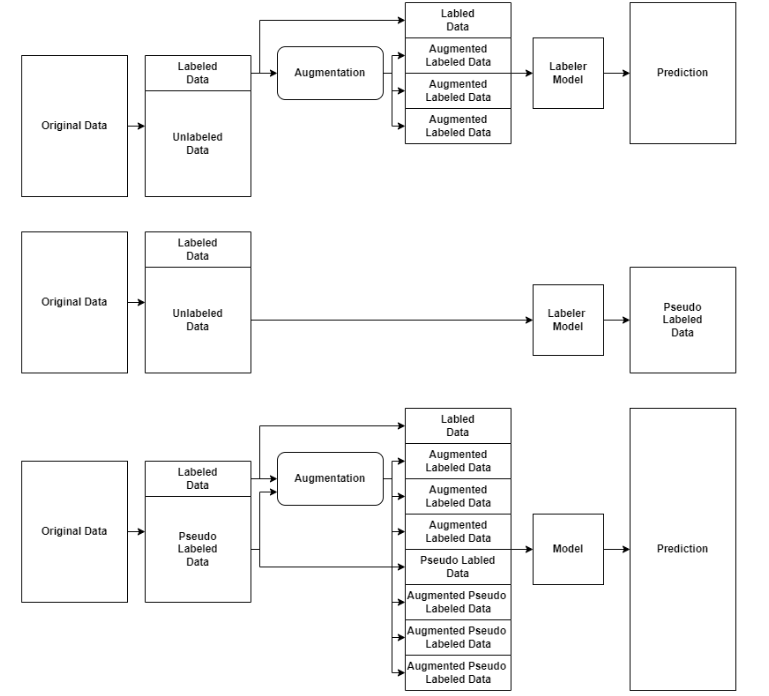

In [ ]:
#Semi-Supervised Learning
if (task == "semi"):

    torch.manual_seed(seed)
    np.random.seed(seed)

    #########################
    '''
    Training the Labeller Model to be used to Label Unlabled Data
    '''
    #########################

    Labeller = ModelClass(device=device, num_classes=len(testloader.dataset.classes), optimizer=optimizer, lr=learn_rate, weight_decay=weight_decay)
    Labeller = Labeller.to(device=device)
    example_ct = 0
    batch_log_interval= 25
    
    for ep in range(epoch):

        Labeller.train()        
        print(f"==========Semi-supervised Learning Labeller Epoch Number: {ep+1}/{epoch}==========")

        if ep == epoch/2:
            learn_rate = learn_rate/10
            print(f"Update Learning Rate: {learn_rate}")
            Labeller.update_lr(learn_rate)

        if ep == 3*epoch/4:
            learn_rate = learn_rate/10
            print(f"Update Learning Rate: {learn_rate}")
            Labeller.update_lr(learn_rate)


        for idx, batch in enumerate(labelledloader):
            data, target = batch
            data = data.to(device=device)
            labels = F.one_hot(target, num_classes = 10).float().to(device=device)
            batch_len = data.shape[0]
            aug_num = []

            if augment_file != None:

                for i in range(len(augment_strength)):
                    aug_num.append(augment_strength[i]*batch_len)

                if len(aug_num) != 1:
                    aug_num = torch.tensor(aug_num)
                    aug_ind = torch.cumsum(aug_num,0).int()
                else:
                    aug_ind = aug_num

                for i in range(len(Aug)):
                    if i == 0:
                        temp_Aug, temp_label = Aug[i](data[0:aug_ind[i]],labels[0:aug_ind[i]])
                        Aug_data = temp_Aug
                        Aug_labels = temp_label
                    else:
                        temp_Aug, temp_label = Aug[i](data[aug_ind[i-1]:aug_ind[i]],labels[aug_ind[i-1]:aug_ind[i]])
                        Aug_data = torch.cat((Aug_data, temp_Aug), 0)
                        Aug_labels = torch.cat((Aug_labels, temp_label), 0)

            else:
                Aug_data = torch.cat((data,data),0)
                Aug_labels = torch.cat((labels,labels),0)


            loss = Labeller.train_sup_up(Aug_data, Aug_labels)
            example_ct += len(Aug_data)

            if idx % batch_log_interval == 0:
                #Logging into WANDB
                print('Train Epoch: {} \tLoss: {:.6f}'.format(ep+1, loss))

                loss = float(loss)
                #wandb.log({"epoch": ep+1, "train/loss": loss}, step=example_ct)
                print(f"Loss after " + str(example_ct).zfill(5) + f" examples: {loss:.3f}")
                
        #Logging into WANDB
        train_loss, train_accuracy = Labeller.test(labelledloader)
        valid_loss, valid_accuracy = Labeller.test(validloader)
        train_loss, train_accuracy, valid_loss, valid_accuracy = float(train_loss), float(train_accuracy), float(valid_loss), float(valid_accuracy)
        #wandb.log({"epoch": ep+1, "train/loss": train_loss, "train/accuracy": train_accuracy, "validation/loss": valid_loss, "validation/accuracy": valid_accuracy}, step=example_ct)	
        print(f"Train Loss/Accuracy after " + str(example_ct).zfill(5) + f" examples: {train_loss:.3f}/{train_accuracy:.3f}")
        print(f"Validation Loss/Accuracy after " + str(example_ct).zfill(5) + f" examples: {valid_loss:.3f}/{valid_accuracy:.3f}")            

            
    
    print()
    print()
    print()

    ############################
    '''
    Curiosity Stuff:
    Check Performance of the Labeller using the unlabled dataloader as test set
    '''
    ############################
    train_loss, train_accuracy = Labeller.test(unlabelledloader)
    train_loss, train_accuracy = float(train_loss), float(train_accuracy)       
    print(f"Unlabelled Dataloader Loss/Accuracy:  {train_loss:.3f}/{train_accuracy:.3f}")
    
    print()
    print()
    print()
    
    ############################
    '''
    Training the Final Model using the Labeller Model to predict for the unlabelled data
    '''
    ############################


    Model = ModelClass(device=device, num_classes=len(testloader.dataset.classes), optimizer=optimizer, lr=learn_rate, weight_decay=weight_decay)
    Model = Model.to(device=device)
    example_ct = 0
    batch_log_interval= 25
    Labeller.eval()

    with wandb.init(project=f"Semi-Supervised Learning {model_file} {data_file}", entity='ift6759-aiadlp', job_type="train", name=f'Config_{num}') as run:
        for ep in range(epoch):
            
            Model.train()
            print(f"==========Semi-supervised Learning Model Epoch Number: {ep+1}/{epoch}==========")
            
            if ep == epoch/2:
                learn_rate = learn_rate/10
                print(f"Update Learning Rate: {learn_rate}")
                Model.update_lr(learn_rate)

            if ep == 3*epoch/4:
                learn_rate = learn_rate/10
                print(f"Update Learning Rate: {learn_rate}")
                Model.update_lr(learn_rate)

            #First Run Through Labelled Dataloader
            for idx, batch in enumerate(labelledloader):
                data, target = batch
                data = data.to(device=device)
                labels = F.one_hot(target, num_classes = 10).float().to(device=device)
                batch_len = data.shape[0]
                aug_num = []

                if augment_file != None:

                    for i in range(len(augment_strength)):
                        aug_num.append(augment_strength[i]*batch_len)

                    if len(aug_num) != 1:
                        aug_num = torch.tensor(aug_num)
                        aug_ind = torch.cumsum(aug_num,0).int()
                    else:
                        aug_ind = aug_num

                    for i in range(len(Aug)):
                        if i == 0:
                            temp_Aug, temp_label = Aug[i](data[0:aug_ind[i]],labels[0:aug_ind[i]])
                            Aug_data = temp_Aug
                            Aug_labels = temp_label
                        else:
                            temp_Aug, temp_label = Aug[i](data[aug_ind[i-1]:aug_ind[i]],labels[aug_ind[i-1]:aug_ind[i]])
                            Aug_data = torch.cat((Aug_data, temp_Aug), 0)
                            Aug_labels = torch.cat((Aug_labels, temp_label), 0)

                else:
                    Aug_data = torch.cat((data,data),0)
                    Aug_labels = torch.cat((labels,labels),0)


                loss = Model.train_sup_up(Aug_data,Aug_labels)
                example_ct += len(Aug_data)

                if idx % batch_log_interval == 0:
                    #Logging into WANDB
                    print('Train Epoch: {} \tLoss: {:.6f}'.format(ep+1, loss))

                    loss = float(loss)
                    wandb.log({"epoch": ep+1, "train/loss": loss}, step=example_ct)
                    print(f"Loss after " + str(example_ct).zfill(5) + f" examples: {loss:.3f}")
                    
                            
            #Second Run Through Unlabelled Dataloader
            for idx, batch in enumerate(unlabelledloader):
                data, _ = batch
                data = data.to(device=device)
                target = torch.argmax(Labeller.forward(data), dim=1)
                labels = F.one_hot(target, num_classes = 10).float().to(device=device)

                batch_len = data.shape[0]
                aug_num = []

                if augment_file != None:

                    for i in range(len(augment_strength)):
                        aug_num.append(augment_strength[i]*batch_len)

                    if len(aug_num) != 1:
                        aug_num = torch.tensor(aug_num)
                        aug_ind = torch.cumsum(aug_num,0).int()
                    else:
                        aug_ind = aug_num

                    for i in range(len(Aug)):
                        if i == 0:
                            temp_Aug, temp_label = Aug[i](data[0:aug_ind[i]],labels[0:aug_ind[i]])
                            Aug_data = temp_Aug
                            Aug_labels = temp_label
                        else:
                            temp_Aug, temp_label = Aug[i](data[aug_ind[i-1]:aug_ind[i]],labels[aug_ind[i-1]:aug_ind[i]])
                            Aug_data = torch.cat((Aug_data, temp_Aug), 0)
                            Aug_labels = torch.cat((Aug_labels, temp_label), 0)

                else:
                    Aug_data = torch.cat((data,data),0)
                    Aug_labels = torch.cat((labels,labels),0)


                loss = Model.train_sup_up(Aug_data,Aug_labels)
                example_ct += len(Aug_data)

                if idx % batch_log_interval == 0:
                    #Logging into WANDB
                    print('Train Epoch: {} \tLoss: {:.6f}'.format(ep+1, loss))

                    loss = float(loss)
                    wandb.log({"epoch": ep+1, "train/loss": loss}, step=example_ct)
                    print(f"Loss after " + str(example_ct).zfill(5) + f" examples: {loss:.3f}")
                
            #Logging into WANDB
            train_loss, train_accuracy = Model.test(labelledloader)
            valid_loss, valid_accuracy = Model.test(validloader)
            train_loss, train_accuracy, valid_loss, valid_accuracy = float(train_loss), float(train_accuracy), float(valid_loss), float(valid_accuracy)
            wandb.log({"epoch": ep+1, "train/loss": train_loss, "train/accuracy": train_accuracy, "validation/loss": valid_loss, "validation/accuracy": valid_accuracy}, step=example_ct)	
            print(f"Train Loss/Accuracy after " + str(example_ct).zfill(5) + f" examples: {train_loss:.3f}/{train_accuracy:.3f}")
            print(f"Validation Loss/Accuracy after " + str(example_ct).zfill(5) + f" examples: {valid_loss:.3f}/{valid_accuracy:.3f}")

    ##########################
    '''
    Evaluation on Test Dataset
    '''
    ##########################
    Model.evaluation(testloader, project=f"Semi-Supervised Learning {model_file} {data_file}", entity='ift6759-aiadlp', name=f'Config_{num}')
    

# More Learning Methods to be added soon...